## Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv 
import scipy.fftpack
from imripy import merger_system as ms
from imripy import halo
from imripy import waveform, detector

## Reading-in CSV data

In [40]:
r    = []                              #Initializing empty array which will hold the r Values
phi  = []                              #Initializing empty array which will hold the phi Values
dr   = []                              #Initializing empty array which will hold the dr Values
dphi = []                              #Initializing empty array which will hold the dphi Values
t    = []                              #Initializing empty array which will hold the t Values


with open("PN_GW_DF_Orb1k_dp100_alpha_2point50.csv") as csv_file:          # Opening and reading the data from the csv file 
    
    csv_reader = csv.reader(csv_file, delimiter=",")
    line_count = 0
    for row in csv_reader:                             # for loop that appends each row from csv file to the array
        r.append(float(row[0]))
        phi.append(float(row[1]))
        dr.append(float(row[2]))
        dphi.append(float(row[3]))
        t.append(float(row[4]))
        line_count = line_count + 1

        
a_start = 0
a_end   = line_count

r = np.array(r[a_start:a_end],dtype=np.longfloat)
phi = np.array(phi[a_start:a_end],dtype=np.longfloat)
dr = np.array(dr[a_start:a_end],dtype=np.longfloat)
dphi = np.array(dphi[a_start:a_end],dtype=np.longfloat)
t = np.array(t[a_start:a_end],dtype=np.longfloat)

print(line_count)

100000


## Orbit Plot

In [41]:
x1 = r*np.cos(phi)
y1 = r*np.sin(phi)

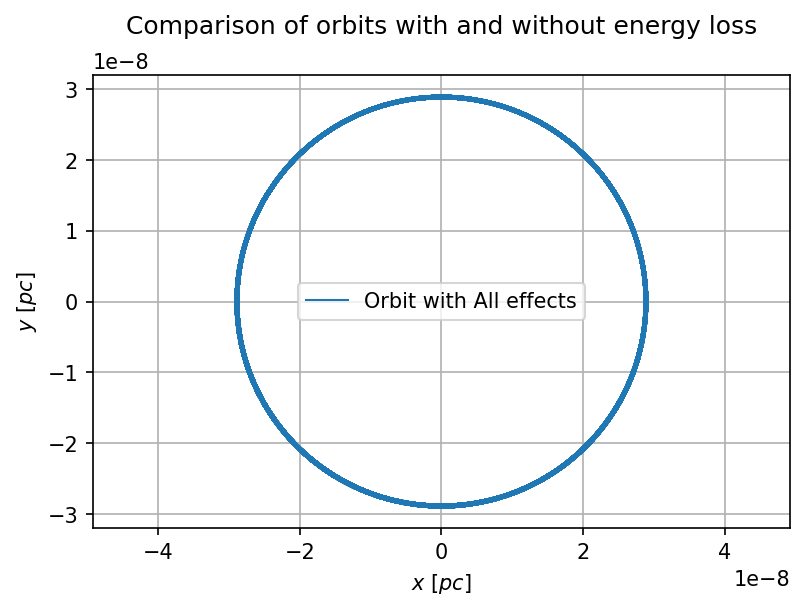

In [42]:
# ------------------------------------------------------------------------------------------
t1 = 0
t2 = line_count

# ------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(6,4), dpi=150)
plt.plot(x1[t1:t2], y1[t1:t2], lw=1, label="Orbit with All effects")
plt.title("Comparison of orbits with and without energy loss",pad=20)
plt.legend(loc=0)
plt.axis('equal')
plt.xlabel("$x$ $[pc]$")
plt.ylabel("$y$ $[pc]$")
plt.grid()
plt.show() 

## Radial Plot

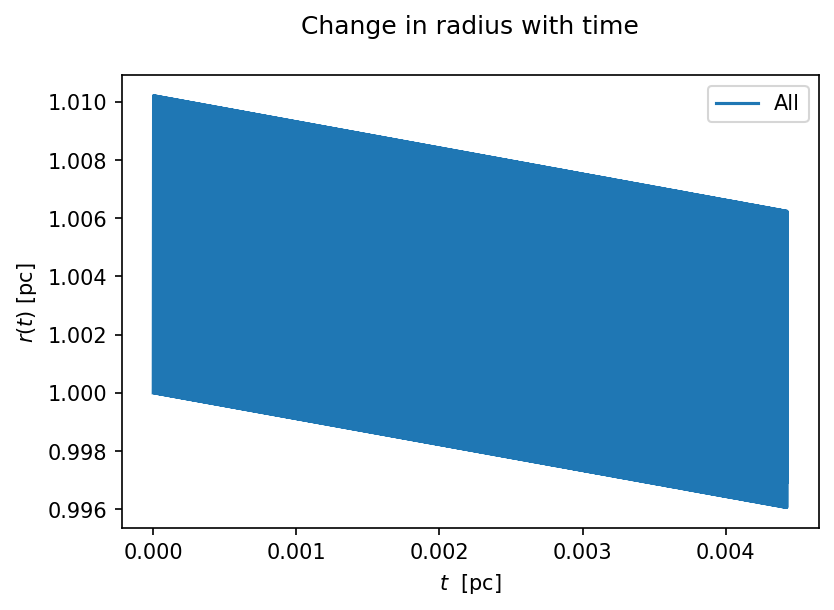

In [43]:
#----------------------------------------------------------------------
r0 = 2.88e-8
r_start = 0
r_end = line_count

#---------------------------------------------------------------------
fig = plt.figure(figsize=(6,4), dpi=150)
plt.plot(t[r_start:r_end], r[r_start:r_end]/r0, label="All")
plt.title("Change in radius with time",pad=20)
plt.legend(loc=0)
#plt.axis('equal')
plt.xlabel("$t$  [pc]")
plt.ylabel("$r(t)$ [pc]")
plt.show()

## Orbital Parameters

In [44]:
#-------------------------System Parameters------------------------------------
m1 = 4.8e-11
m2 = 4.8e-14
D  = 1e5 
a0 = 2.88e-8
e0 = 0.

#---------------------------Mass Arrays-----------------------------------------
m_total = m1+m2
mu = (m1*m2)/(m1+m2)
mass=[m1,m2,m_total,mu]

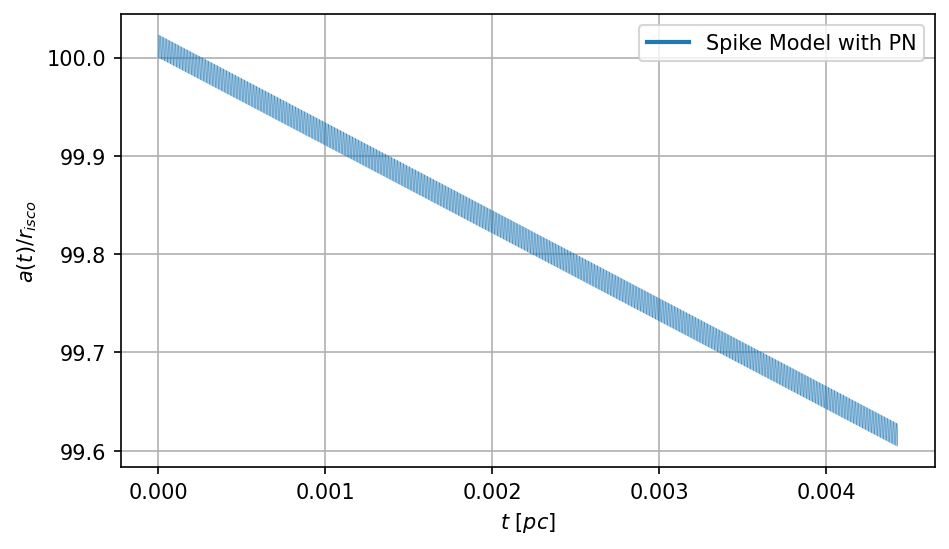

In [45]:
#---------------------------Semi-major axis-------------------------------------
v = np.sqrt(dr**2 + r**2 * dphi**2)
sma = m_total/np.abs(v**2 - 2*m_total/r)

#----------------------------Plotting-------------------------------------------
timescale=1.
r_isco = 2.88e-10

a1 = 0
a2 = line_count


fig, ax = plt.subplots(figsize=(7,4), dpi=150)
ax.plot(t[a1:a2]/timescale, sma[a1:a2]/r_isco, label="Spike Model with PN", linewidth=0.1)
leg = ax.legend()

for line in leg.get_lines():
    line.set_linewidth(2.0)
plt.ylabel(r'$a(t)/r_{isco}$')
plt.xlabel(r'$t$ $[pc]$')
plt.grid()
plt.show()

## Gravitational Wave Signal

In [34]:
def strain(mass, D, r, phi, t):

    #Observer parameters
    mu = mass[3]
    theta_o = 0    # inclination_angle
    phi_o = 0      # pericenter_angle

    #Rotating body parameters
    x = r*np.cos(phi)
    y = r*np.sin(phi)
    z = np.zeros(np.shape(x))
    
    Q=[ [mu*x*x, mu*x*y, mu*x*z],
           [mu*y*x, mu*y*y, mu*y*z],
           [mu*z*x, mu*z*y, mu*z*z] ]
    
    def Mdt(Q):
        return np.array([ [np.gradient(Q[0][0], t), np.gradient(Q[0][1], t), np.gradient(Q[0][2], t)], 
                            [np.gradient(Q[1][0], t),np.gradient(Q[1][1], t),np.gradient(Q[1][2], t)],
                            [np.gradient(Q[2][0], t),np.gradient(Q[2][1], t),np.gradient(Q[2][2], t)] ])
    dQdt=Mdt(Q)
    d2Qd2t=Mdt(dQdt)
    
    h_plus =  1./D * ( d2Qd2t[0][0] * (np.cos(phi_o)**2 - np.sin(phi_o)**2 * np.cos(theta_o)**2) 
                         + d2Qd2t[1][1] * (np.sin(phi_o)**2 - np.cos(phi_o)**2 * np.cos(theta_o)**2) 
                         - d2Qd2t[2][2] * np.sin(theta_o)**2 
                         - d2Qd2t[0][1] * np.sin(2*phi_o) * (1. + np.cos(theta_o)**2)
                         + d2Qd2t[0][2] * np.sin(phi_o) * np.sin(2*theta_o) 
                         + d2Qd2t[1][2] * np.cos(phi_o) * np.sin(2*theta_o) )      
    h_cross = 1./D * ( (d2Qd2t[0][0]-d2Qd2t[1][1]) * np.sin(2*phi_o)*np.cos(theta_o)
                         + 2. * d2Qd2t[0][1] * np.cos(2*phi_o)*np.cos(theta_o) 
                         - 2. * d2Qd2t[0][2] * np.cos(phi_o)*np.sin(theta_o) 
                         + 2. * d2Qd2t[1][2] * np.sin(theta_o)*np.sin(phi_o) )

    strain = np.array([h_plus,h_cross])

    return strain


def strainFFT(t, strain, f_bin):
    N = len(t)
    T = t[1] - t[0]
    
    h_plus_fft = scipy.fftpack.fft(strain[0,:])/(2*np.pi*N)
    h_cross_fft = scipy.fftpack.fft(strain[1,:])/(2*np.pi*N)
    xf = scipy.fftpack.fftfreq(N, T)[:N//2]
    
    h_plus_fft = h_plus_fft[np.where((xf > f_bin[0]) & (xf < f_bin[1]))]
    h_cross_fft = h_cross_fft[np.where((xf > f_bin[0]) & (xf < f_bin[1]))]
    xf = xf[np.where((xf > f_bin[0]) & (xf < f_bin[1]))]
    
    out = np.array([xf, h_plus_fft, h_cross_fft])
    
    return out


In [35]:
# Calculate GW signal

strain_spike     = strain(mass, D, r, phi, t)
strain_FFT_spike = strainFFT(t, strain_spike, [1e-4*ms.hz_to_invpc, 1e-1*ms.hz_to_invpc])


## Plot the Gravitational waveform

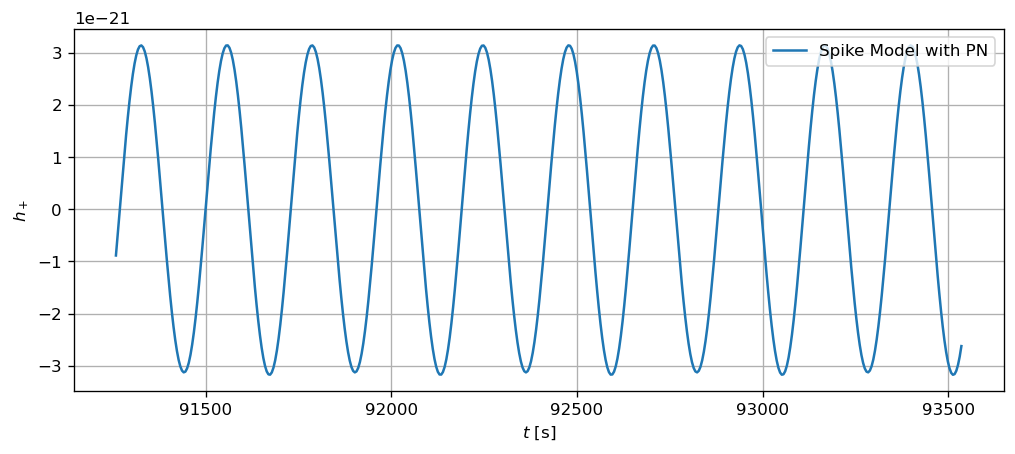

In [36]:

#-------------------------------------------------------------------------------------------
yr_to_s = 31556952

tstart=20000
tend=20500

#-------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(10,4), dpi=120) 
plt.plot(yr_to_s*(t[tstart:tend]/ms.year_to_pc), strain_spike[0,tstart:tend], label='Spike Model with PN')
#plt.xlim(0.,yr_to_s*(10./F0/ms.year_to_pc))
plt.xlabel("$t$ [s]")
plt.ylabel("$h_+$")
plt.grid() 
plt.legend(loc=1)

## Characteristic Strain

C:\Users\hazke\miniconda3\envs\p4env\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


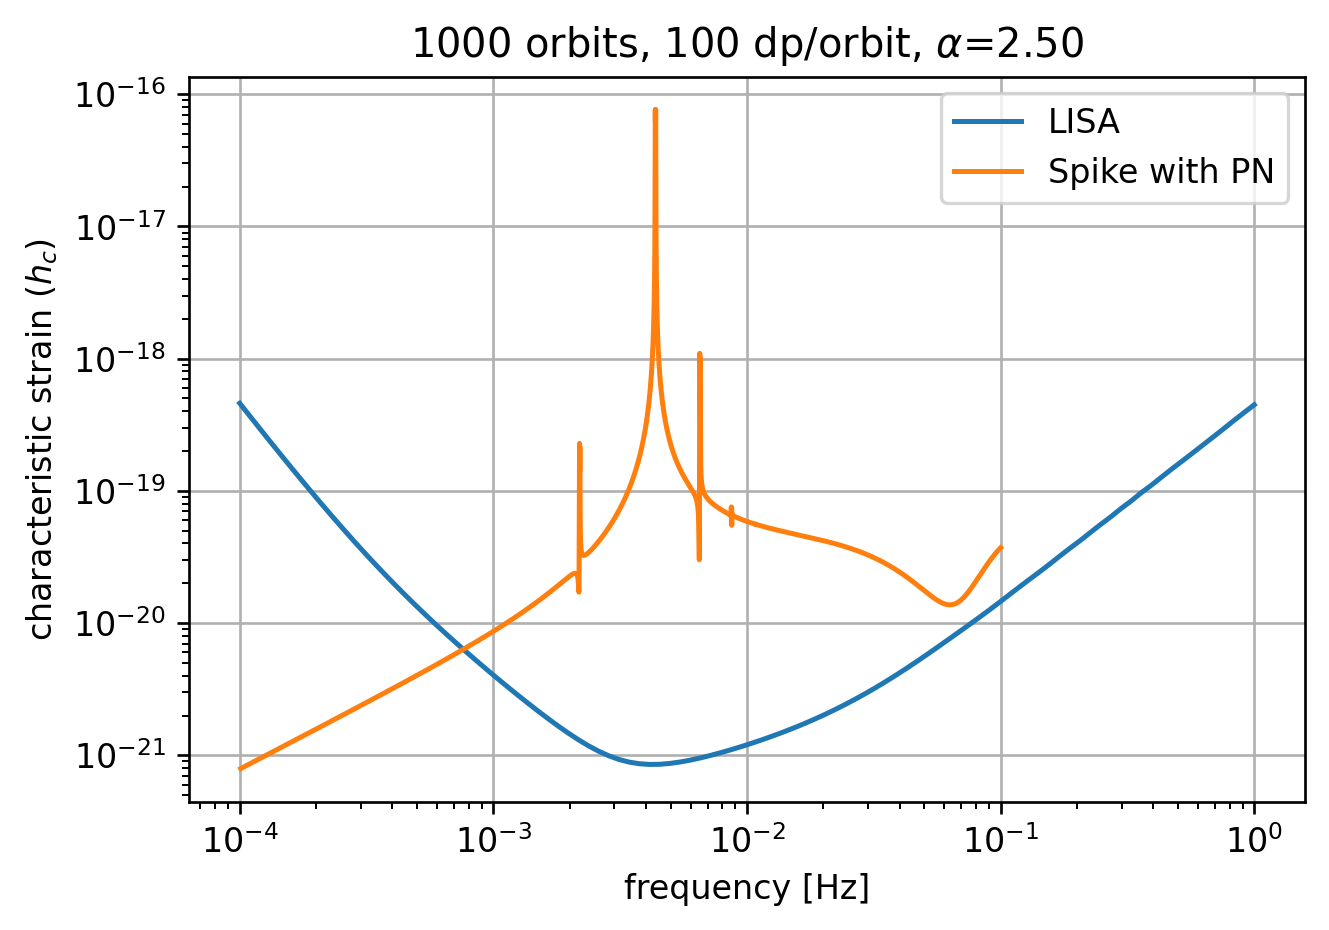

In [38]:
#The characteristic strain (basically fourier transform) of the signal compared to the LISA sensitivity (check Niklas-Rastgoo paper)

#-------------------LISA curve----------------------------------------------
fig = plt.figure(figsize=(6,4), dpi=240)
Lisa = detector.Lisa()
f_gw = np.geomspace(Lisa.Bandwith()[0], Lisa.Bandwith()[1], 100)
plt.loglog(f_gw/ms.hz_to_invpc, Lisa.NoiseStrain(f_gw), label='LISA')



#----------------Characteristic Strain---------------------------------------

f_start = 0
f_end   = len(strain_FFT_spike[0])

frequency = strain_FFT_spike[0,f_start:f_end]/ms.hz_to_invpc
h_char = 2.*strain_FFT_spike[0,f_start:f_end]*np.abs(strain_FFT_spike[1,f_start:f_end])

plt.loglog(frequency, h_char,label='Spike with PN' )
plt.grid(); plt.legend(loc=0); plt.xlabel("frequency [Hz]"); plt.ylabel("characteristic strain ($h_{c}$)")
plt.title(r'1000 orbits, 100 dp/orbit, $\alpha$=2.50')
#plt.savefig('hc_GW_DF_Orb132k_dp100_alpha_2point53.jpg')
plt.show()

In [ ]:
%reset

## Precession

In [39]:
# Will add soon